In [4]:
#Problem: A cancer hospital has provided data and wants us to determine if a patient has a fatal malignant cancer vs. a benign 
#growth. This is known as a classification problem. To help classify each patient, we are given their age and the size of the 
#tumor. Intuitively, one can imagine that younger patients and/or patients with small tumors are less likely to have a malignant 
#cancer. The data set simulates this application: each observation is a patient represented as a dot (in the plot below), where 
#red indicates malignant and blue indicates benign. Note: This is a toy example for learning; in real life many features from 
#different tests/examination sources and the expertise of doctors would play into the diagnosis/treatment decision for a patient.

In [6]:
from IPython.display import Image
# Figure 3
Image(url= "https://www.cntk.ai/jup/logistic_neuron.jpg", width=300, height=200)

In [9]:
#Approach:
#Learning algo has typically got 5 stages:
    #1) Data Reading
    #2)Data Preprocessing
    #3)Creating a model
    #4)learning the model parameters
    #5)Evaluating the model(testing/prediction)   

In [10]:
#import relevant components
from __future__ import print_function
import numpy as np
import sys
import os
import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() #only needed for our build systems
C.cntk_py.set_fixed_random_seed(1) #fix the random seed so that the LR examples are repeatable

In [12]:
#Data Generation: generate some synthetic data emulating the cancer example using the numpy library

#Define the network
input_dim=2
num_output_classes=2

In [14]:
#Ensure that we always the same result
np.random.seed(0)

#Helper function to generate random data sample
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    #Create synthetic data using numpy
    Y=np.random.randint(size=(sample_size,1), low=0, high=num_classes)
    
    #Make sure that teh data is separable
    X= (np.random.randn(sample_size, feature_dim)+3)*(Y+1)
    
    #Specify the data type to match the input variable used later (default is double)
    X=X.astype(np.float32)
    
    #Convert class 0 vector into "1 0 0", class vector 1 into '0 1 0', ...
    class_ind=[Y==class_number for class_number in range(num_classes)]
    Y=np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y

In [19]:
#Create the input variables denoting the features and input data. 
#Note: the input does not need additional info on the number of observations(samples) 
#since creates only the Network Topology first

mysamplesize=32
features, labels= generate_random_data_sample(mysamplesize, input_dim, num_output_classes)
print(features)
print(labels)

[[1.9292474 4.054452 ]
 [5.193646  8.44489  ]
 [3.208275  3.976639 ]
 [3.3563664 3.7065732]
 [3.0105    4.7858706]
 [6.253824  6.803979 ]
 [4.8831506 1.652241 ]
 [1.729515  3.9693966]
 [3.6537533 9.887242 ]
 [2.586381  2.252545 ]
 [9.845884  8.96103  ]
 [4.867559  3.9060447]
 [2.1387744 4.910065 ]
 [5.463993  7.6049128]
 [7.894504  5.68998  ]
 [3.6140795 3.9222066]
 [3.3764255 1.9005992]
 [3.2982383 4.326386 ]
 [4.610864  5.700731 ]
 [5.129693  9.698527 ]
 [3.6722949 3.407462 ]
 [2.230084  3.5392492]
 [2.3256674 3.0318305]
 [2.3641539 3.6764333]
 [3.5765908 2.7917013]
 [6.7920136 3.8138769]
 [1.5087425 3.4393916]
 [6.333347  7.270063 ]
 [5.383145  3.9444795]
 [2.0871778 4.1170163]
 [1.6840926 2.5384154]
 [5.863517  9.426685 ]]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [

<function matplotlib.pyplot.show(*args, **kw)>

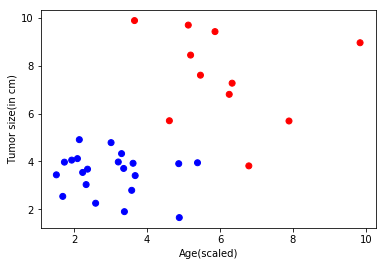

In [21]:
#Visualize the input data
import matplotlib.pyplot as plt
%matplotlib inline

#let 0 represent malignant(red) and 1 represent benign(blue)
colors=['r' if label==0 else 'b' for label in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Age(scaled)")
plt.ylabel("Tumor size(in cm)")
plt.show    

In [22]:
#Model creation
Image(url= "https://www.cntk.ai/jup/logistic_neuron2.jpg", width=300, height=200)

#The computed evidence is mapped to a (0, 1) range using a sigmoid (when the outcome can be in one of two 
#possible classes) or a softmax function (when the outcome can be in one of more than two possible classes)

In [23]:
feature=C.input_variable(input_dim, np.float32)

In [30]:
#Network setup

#Define a dictionary to store the model parameters
mydict={}

def linear_layer(input_var, output_dim):
    input_dim=input_var.shape[0]
    weight_param=C.parameter(shape=(input_dim, output_dim))
    bias_param=C.parameter(shape=(output_dim))
    
    mydict['w'], mydict['b'] =weight_param, bias_param
    
    return C.times(input_var, weight_param) +bias_param

In [31]:
output_dim=num_output_classes
z=linear_layer(feature, output_dim)

In [33]:
label=C.input_variable(num_output_classes, np.float32)
loss=C.cross_entropy_with_softmax(z, label)

In [34]:
#Evaluation
eval_error=C.classification_error(z, label)

In [35]:
#Instantiate the trainer object to drive the model training
learning_rate=0.5
lr_schedule=C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner=C.sgd(z.parameters, lr_schedule)
trainer=C.Trainer(z, (loss, eval_error), [learner])

In [45]:
#Define a utility function to compute the moving average
#A more efficient implementation is possible with np.cumsum() function

def moving_average(a, w=10):
    if len(a)<w:
        return a[:]
    return [val if idx<w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

#Define utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error="NA", "NA"
    
    if mb % frequency ==0:
        training_loss=trainer.previous_minibatch_loss_average
        eval_error=trainer.previous_minibatch_evaluation_average
        if verbose:
            print(" Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))
    
    return mb, training_loss, eval_error
 

In [46]:
#Initialize the parameters for the trainer
minibatch_size=25
num_samples_to_train= 20000
num_minibatches_to_train=int(num_samples_to_train/minibatch_size)

In [48]:
from collections import defaultdict

#Run the trainer and perform model training
training_progress_output_freq=10
plotdata=defaultdict(list)

for i in range(0, num_minibatches_to_train):
    features, labels=generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    #Assign the minibatch data to the input variables and train the model on minibatch
    trainer.train_minibatch({feature: features, label: labels})
    batchsize, loss, error=print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss=="NA" or error== "NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

 Minibatch: 0, Loss: 1.4134, Error: 0.48
 Minibatch: 10, Loss: 0.8933, Error: 0.52
 Minibatch: 20, Loss: 7.4533, Error: 0.52
 Minibatch: 30, Loss: 1.1670, Error: 0.44
 Minibatch: 40, Loss: 1.9671, Error: 0.36
 Minibatch: 50, Loss: 0.3032, Error: 0.16
 Minibatch: 60, Loss: 4.3625, Error: 0.44
 Minibatch: 70, Loss: 1.9847, Error: 0.56
 Minibatch: 80, Loss: 0.7009, Error: 0.32
 Minibatch: 90, Loss: 0.4212, Error: 0.12
 Minibatch: 100, Loss: 0.9012, Error: 0.44
 Minibatch: 110, Loss: 0.6770, Error: 0.24
 Minibatch: 120, Loss: 0.5506, Error: 0.16
 Minibatch: 130, Loss: 0.2169, Error: 0.08
 Minibatch: 140, Loss: 0.4115, Error: 0.16
 Minibatch: 150, Loss: 0.3882, Error: 0.12
 Minibatch: 160, Loss: 0.1898, Error: 0.04
 Minibatch: 170, Loss: 0.1464, Error: 0.04
 Minibatch: 180, Loss: 0.3273, Error: 0.08
 Minibatch: 190, Loss: 0.2661, Error: 0.12
 Minibatch: 200, Loss: 0.2048, Error: 0.08
 Minibatch: 210, Loss: 0.7793, Error: 0.16
 Minibatch: 220, Loss: 0.4957, Error: 0.24
 Minibatch: 230, Loss:

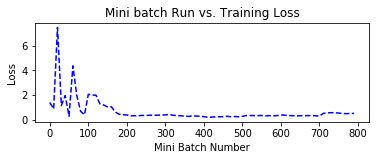

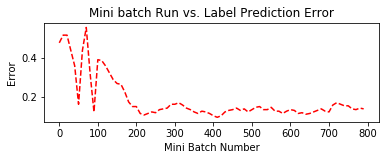

In [52]:
#Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"]=moving_average(plotdata["loss"])
plotdata["avgerror"]=moving_average(plotdata["error"])

#Plot the training loss and training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel("Mini Batch Number")
plt.ylabel("Loss")
plt.title("Mini batch Run vs. Training Loss")
plt.show()

plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel("Mini Batch Number")
plt.ylabel("Error")
plt.title("Mini batch Run vs. Label Prediction Error")
plt.show()




In [55]:
#Run the train model on a newly generated dataset
test_minibatch_size=25
features, labels=generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({feature:features, label: labels})

0.08

In [56]:
#Checking prediction / evaluation
out= C.softmax(z)
result=out.eval({feature:features})


In [59]:
print("Label:     ", [np.argmax(label) for label in labels])
print("Predicted: ", [np.argmax(x) for x in result])

Label:      [1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1]
Predicted:  [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1]


[ 7.9521217 -7.9521227]


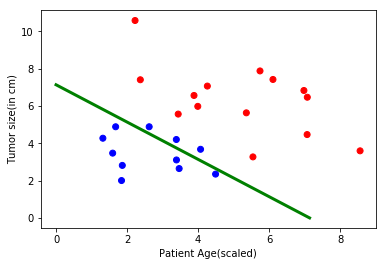

In [61]:
#Visualization

#Model parameters
print(mydict['b'].value)

bias_vector=mydict['b'].value
weight_matrix=mydict['w'].value

#Plot the data
#0 represent malignant(red) and 1 represent benign(blue)
colors=['r' if label==0 else 'b'  for label in labels[:,0]]
plt.scatter(features[:,0], features[:,1], c=colors)
plt.plot([0, bias_vector[0]/weight_matrix[0][1]],
         [bias_vector[1]/weight_matrix[0][0],0], c='g', lw=3)

plt.xlabel("Patient Age(scaled)")
plt.ylabel("Tumor size(in cm)")
plt.show()

          
          
          
          